<a href="https://colab.research.google.com/github/IsaacFigNewton/DisCoFuzz/blob/main/DisCoFuzz_WF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Config

## Download, install dependencies

In [1]:
!pip install POT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.9 MB/s eta 0:00:00


## Import

In [2]:
from typing import Callable, Dict, List, Tuple, Set
import math
import numpy as np
import random
import nltk

nltk.download('wordnet')
nltk.download('framenet-17')
nltk.download('stopwords')
from nltk.corpus import wordnet as wn
from nltk.corpus import framenet as fn
from nltk.corpus import stopwords

import spacy

import pandas as pd

import scipy.stats as stats
from scipy.special import expit, logit

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

import tensorflow as tf

import ot

from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Error loading framenet-17: Package 'framenet-17' not found
[nltk_data]     in index
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Config

In [3]:
stop_words = stopwords.words("english")
all_synsets = list(wn.all_synsets())
wn_dict = {
    'synset': list(),
    'lemmas': list(),
    'antonyms': list(),
    'gloss': list(),
    "cleaned_gloss": list(),
}

for s in all_synsets:
  lemmas = s.lemmas()
  antonyms = list()
  for lemma in lemmas:
    antonyms += list(lemma.antonyms())
  if len(lemmas) > 1 and len(antonyms) > 0:
    wn_dict['synset'].append(s.name())
    wn_dict['lemmas'].append([l.name() for l in lemmas])
    wn_dict['antonyms'].append([a.name() for a in antonyms])
    wn_dict['gloss'].append(s.definition())
    cleaned_gloss = " ".join([t for t in s.definition().split(" ") if t not in stop_words])
    wn_dict['cleaned_gloss'].append(cleaned_gloss.replace("_", " "))

wn_df = pd.DataFrame.from_dict(wn_dict)
wn_df.head()

,synset,lemmas,antonyms,gloss,cleaned_gloss
0,abaxial.a.01,"[abaxial, dorsal]",[adaxial],facing away from the axis of an organ or organism,facing away axis organ organism
1,adaxial.a.01,"[adaxial, ventral]",[abaxial],nearest to or facing toward the axis of an org...,nearest facing toward axis organ organism
2,abducent.a.01,"[abducent, abducting]",[adducent],especially of muscles; drawing away from the m...,especially muscles; drawing away midline body ...
3,adducent.a.01,"[adducent, adductive, adducting]",[abducent],especially of muscles; bringing together or dr...,especially muscles; bringing together drawing ...
4,relative.a.01,"[relative, comparative]",[absolute],estimated by comparison; not absolute or complete,estimated comparison; absolute complete


In [4]:
wn_df = wn_df.sample(frac=0.5).reset_index(drop=True)
print(f'Number of synsets: {len(wn_df)}')

Number of synsets: 1334


In [5]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

# Classes

## LemmaVectorizer

In [7]:
class LemmaVectorizer:
    def __init__(self, jit_vectorization = False):
        self.embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
        self.keyed_vectors = None
        if not jit_vectorization:
          self.keyed_vectors = self.build_wordnet_lemma_embeddings()

    def build_wordnet_lemma_embeddings(
        self,
        batch_size: int = 64
    ):
        """
        Loads all WordNet lemmas, embeds them using a SentenceTransformer model,
        and returns a dictionary mapping lemma → embedding vector.

        Args:
            batch_size: Batch size for model.encode().

        Returns:
            dict[str, np.ndarray]: mapping from lemma string to embedding vector.
        """
        # Collect all lemmas (set removes duplicates)
        lemma_set = set()
        for syn in wn.all_synsets():
            for lemma in syn.lemmas():
                lemma_set.add(lemma.name().replace("_", " "))  # normalize underscore → space

        lemma_list = sorted(lemma_set)

        # Encode lemmas in batches
        embeddings = self.embedding_model.encode(
            lemma_list,
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True
        )

        # Build dictionary
        lemma_to_vec = {lemma: emb for lemma, emb in zip(lemma_list, embeddings)}

        return lemma_to_vec

    def __call__(self, X: str) -> np.ndarray:
        if self.keyed_vectors:
            v = self.keyed_vectors.get(X)#.lemma_.lower())
            if v is not None:
                return np.asarray(v, dtype=float)
        return self.embedding_model.encode([X])

## FourierPDF
for probability density function operations

In [8]:
class FourierPDF:
  def __init__(self, kernel_size:int):
    self.kernel_size = kernel_size
    # get frequencies
    self.k_values = tf.cast(
        tf.range(0, kernel_size),
        tf.complex64
    )
    # pre-computer partial divisor for faster integration
    #   shape=(, self.kernel_size)
    # add 1e-20 to avoid division by 0
    self.divisor = tf.expand_dims(
        self.k_values+1e-20,
        axis=0
    )

  def _get_cdf_batch(self, a: tf.Tensor) -> tf.Tensor:
      """
      Batch integration.
      a: shape (batch_size, kernel_size)
      Returns: shape (batch_size,)
      """
      if len(tf.shape(a)) != 2:
          raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")
      if a.dtype != tf.complex64:
          raise ValueError(f"Input tensors must be complex64, received {a.dtype}")

      batch_size = tf.shape(a)[0]
      # Create indices for the k=0 term for each item in the batch
      indices = tf.stack([tf.range(batch_size), tf.zeros(batch_size, dtype=tf.int32)], axis=1)

      # get AC term (just set all k=0 values to 0)
      AC = tf.tensor_scatter_nd_update(
          a,
          indices,
          tf.zeros(batch_size, dtype=tf.complex64)
      )
      # get divisors
      divisor = tf.broadcast_to(
          self.divisor,
          [tf.shape(a)[0], self.kernel_size]
      )
      AC = AC / divisor

      # add the k=0 terms back in
      return tf.tensor_scatter_nd_update(
          AC,
          indices,
          a[:, 0]
      )

  def _integrate_batch(self, a: tf.Tensor, ub:float=1, lb:float=0) -> tf.Tensor:
      """
      Batch integration.
      a: shape (batch_size, kernel_size)
      Returns: shape (batch_size,)
      """
      if len(tf.shape(a)) != 2:
          raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")
      if a.dtype != tf.complex64:
          raise ValueError(f"Input tensors must be complex64, received {a.dtype}")

      batch_size = tf.shape(a)[0]

      # Create indices for the k=0 term for each item in the batch
      indices = tf.stack([tf.range(batch_size), tf.zeros(batch_size, dtype=tf.int32)], axis=1)

      # get AC term (just set all k=0 values to 0)
      AC = tf.tensor_scatter_nd_update(
          a,
          indices,
          tf.zeros(batch_size, dtype=tf.complex64)
      )
      # get divisors
      divisor = tf.broadcast_to(
          self.divisor,
          [tf.shape(a)[0], self.kernel_size],
      )

      upper_bound = tf.exp(divisor * ub)
      lower_bound = tf.exp(divisor * lb)
      diff = upper_bound - lower_bound

      integrals_k_nonzero = tf.reduce_sum(
          (AC / divisor) * diff,
          axis=1
      )

      # Combine k=0 and k>0 terms
      return a[:, 0] + integrals_k_nonzero

  def _integrate(self, a: tf.Tensor, ub:float=1, lb:float=0) -> tf.Tensor:
      """
      Single integration helper.
      a: shape (kernel_size)
      Returns: scalar
      """
      if len(tf.shape(a)) != 1:
          raise ValueError(f"Input tensor must have shape (kernel_size,), received tensor of shape {tf.shape(a)}")
      if a.dtype != tf.complex64:
          raise ValueError(f"Input tensors must be complex64, received {a.dtype}")

      a_batch = tf.expand_dims(a, axis=0)
      result_batch = self._integrate_batch(a_batch, ub, lb)
      return tf.squeeze(result_batch)

  def _normalize_batch(self, a: tf.Tensor) -> tf.Tensor:
      """
      Batch normalization of probability density functions.
      a: shape (batch_size, kernel_size)
      """
      if len(tf.shape(a)) != 2:
          raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")
      if a.dtype != tf.complex64:
          raise ValueError(f"Input tensor must be complex64, received {a.dtype}")

      total_integral = self._integrate_batch(a)  # (batch_size,)
      total_integral = tf.expand_dims(total_integral, 1)  # (batch_size, 1)

      # Avoid division by zero
      total_integral = tf.where(
          tf.abs(total_integral) > 1e-10,
          total_integral,
          tf.ones_like(total_integral)
      )

      return a / total_integral

  def _normalize(self, a: tf.Tensor) -> tf.Tensor:
      """
      Single normalization helper for normalizing probability density functions.
      a: shape (kernel_size,)
      Returns: shape (kernel_size,)
      """
      if len(tf.shape(a)) != 1:
          raise ValueError(f"Input tensor must have shape (kernel_size,), received tensor of shape {tf.shape(a)}")
      if a.dtype != tf.complex64:
          raise ValueError(f"Input tensor must be complex64, received {a.dtype}")

      a_batch = tf.expand_dims(a, axis=0)
      result_batch = self._normalize_batch(a_batch)
      return tf.squeeze(result_batch, axis=0)

  def _convolve_batch(self, a: tf.Tensor, b: tf.Tensor) -> tf.Tensor:
      """
      Batch convolution using FFT.
      a, b: shape (batch_size, kernel_size)
      Returns: shape (batch_size, kernel_size)
      """
      if len(tf.shape(a)) != 2:
          raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")
      if len(tf.shape(b)) != 2:
          raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(b)}")

      # Batch FFT convolution
      A_fft = tf.signal.fft(tf.cast(a, tf.complex64))
      B_fft = tf.signal.fft(tf.cast(b, tf.complex64))
      C_fft = A_fft * B_fft
      C = tf.signal.ifft(C_fft)

      return tf.cast(C, tf.complex64)

  def _convolve(self, a: tf.Tensor, b: tf.Tensor) -> tf.Tensor:
      """
      Single convolution helper.
      a, b: shape (kernel_size,)
      Returns: shape (kernel_size,)
      """
      a_batch = tf.expand_dims(a, axis=0)
      b_batch = tf.expand_dims(b, axis=0)
      result_batch = self._convolve_batch(a_batch, b_batch)
      return tf.squeeze(result_batch, axis=0)

  def _differentiate_batch(self, a: tf.Tensor) -> tf.Tensor:
      """
      Batch differentiation.
      a: shape (batch_size, kernel_size)
      Returns: shape (batch_size, kernel_size)
      """
      if len(tf.shape(a)) != 2:
          raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")

      return a * tf.exp(1j * self.k_values)

  def _differentiate(self, a: tf.Tensor) -> tf.Tensor:
      """
      Single differentiation helper.
      a: shape (kernel_size,)
      Returns: shape (kernel_size,)
      """
      a_batch = tf.expand_dims(a, axis=0)
      result_batch = self._differentiate_batch(a_batch)
      return tf.squeeze(result_batch, axis=0)

## Fuzzification Classes

### FuzzyFourierSetMixin

In [19]:
class FuzzyFourierSetMixin(FourierPDF):
  def __init__(self, sigma: float, kernel_size: int):
      if kernel_size < 1:
          raise ValueError("Kernel size must be at least 1")
      super().__init__(kernel_size)
      self.sigma = tf.constant(sigma, dtype=tf.complex64)

      # Pre-compute Fourier coefficients for all k values
      # C_k = e^{-\frac{a^{2}k^{2}}{2}} and keep mu portion separate for now
      c_k = tf.exp(-0.5 * (self.sigma ** 2) * (self.k_values ** 2))
      self.fourier_coeffs = c_k / (2 * np.pi)

  def _get_gaussian_at_mu_batch(self, mu: tf.Tensor) -> tf.Tensor:
      """
      Batch computation of Fourier series for Gaussians centered at multiple mu values.
      mu: shape (batch_size,)
      Returns: shape (batch_size, kernel_size)
      """
      # mu part of C_n = e^{-ikb}
      #   combine mu.shape = (batch_size,) with self.k_values.T.shape = (,self.kernel_size)
      #   to get tensor of shape (batch_size, self.kernel_size)
      mu_c_k = tf.linalg.matmul(
          tf.expand_dims(tf.cast(mu, dtype=tf.complex64), axis=1),
          tf.expand_dims(self.k_values, axis=0)
      )
      mu_c_k = tf.exp(-1j * mu_c_k)

      # combine (batch_size, self.kernel_size) with (self.kernel_size,) self.fourier_coeffs
      return self._normalize_batch(mu_c_k * self.fourier_coeffs)

  def fuzzify(self, component: float) -> tf.Tensor:
      """
      Convert a real-valued component to a Fourier series representation of a Gaussian.
      component: scalar float
      Returns: shape (kernel_size,)
      """
      mu = tf.constant([component], dtype=tf.float32)
      gaussian = self._get_gaussian_at_mu_batch(mu)
      normalized = self._normalize_batch(gaussian)
      return tf.squeeze(normalized, axis=0)

  def fuzzify_batch(self, components: tf.Tensor) -> tf.Tensor:
      """
      Batch fuzzification.
      components: shape (batch_size,)
      Returns: shape (batch_size, kernel_size)
      """
      if len(tf.shape(components)) != 1:  # Fixed: was checking for 3
          raise ValueError(f"Input tensor must have shape (batch_size,), received tensor of shape {tf.shape(components)}")

      gaussians = self._get_gaussian_at_mu_batch(components)
      return self._normalize_batch(gaussians)

  def negation(self, a: tf.Tensor) -> tf.Tensor:
      """
      Fuzzy negation: NOT(a) = 1 - a
      a: shape (kernel_size,)
      Returns: shape (kernel_size,)
      """
      # Create representation of constant function 1
      one = tf.zeros_like(a)
      one = tf.tensor_scatter_nd_update(
          one,
          [[0]],
          [tf.constant(1.0, dtype=tf.complex64)]
      )

      return self._normalize(one - a)

  def negation_batch(self, a: tf.Tensor) -> tf.Tensor:
      """
      Batch fuzzy negation: NOT(a) = 1 - a
      a: shape (batch_size, kernel_size)
      Returns: shape (batch_size, kernel_size)
      """
      if len(tf.shape(a)) != 2:
          raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")
      batch_size = tf.shape(a)[0]

      # Create batch of constant function 1
      # base tensor of same shape as a
      ones = tf.zeros_like(a)
      # indices at which to place 1's
      indices = tf.stack([
          tf.range(batch_size),
          tf.zeros(batch_size, dtype=tf.int32)
      ], axis=1)
      # ones to be inserted at said indices
      updates = tf.ones([batch_size], dtype=tf.complex64)
      # update the base tensor with 1's
      ones = tf.tensor_scatter_nd_update(ones, indices, updates)

      # get normalized negation
      return self._normalize_batch(ones - a)

  def intersection(self, a: tf.Tensor, b: tf.Tensor, normalize: bool = True) -> tf.Tensor:
      """
      Fuzzy intersection using product (min approximation).
      a, b: shape (kernel_size,)
      Returns: shape (kernel_size,)
      """
      result = self._convolve(a, b)
      if normalize:
          result = self._normalize(result)
      return result

  def intersection_batch(self, a: tf.Tensor, b: tf.Tensor, normalize: bool = True) -> tf.Tensor:
      """
      Batch fuzzy intersection using product.
      a, b: shape (batch_size, kernel_size)
      Returns: shape (batch_size, kernel_size)
      """
      if len(tf.shape(a)) != 2:
          raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")
      result = self._convolve_batch(a, b)
      if normalize:
          result = self._normalize_batch(result)
      return result

  def union(self, a: tf.Tensor, b: tf.Tensor, normalize: bool = True) -> tf.Tensor:
      """
      Fuzzy union: a + b - a*b
      a, b: shape (kernel_size,)
      Returns: shape (kernel_size,)
      """
      convolved = self._convolve(a, b)
      result = a + b - convolved
      if normalize:
          result = self._normalize(result)
      return result

  def union_batch(self, a: tf.Tensor, b: tf.Tensor, normalize: bool = True) -> tf.Tensor:
      """
      Batch fuzzy union: a + b - a*b
      a, b: shape (batch_size, kernel_size)
      Returns: shape (batch_size, kernel_size)
      """
      if len(tf.shape(a)) != 2:
          raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")
      convolved = self._convolve_batch(a, b)
      result = a + b - convolved
      if normalize:
          result = self._normalize_batch(result)
      return result

### FourierFuzzifier

WF geodesic calculation functions based on [the work by Elsa Cazelles, Arnaud Robert, Felipe Tobar](https://github.com/GAMES-UChile/Wasserstein-Fourier.git) in their paper ["The Wasserstein-Fourier Distance for Stationary Time Series"](https://arxiv.org/abs/1912.05509) to make it compatible with the component-wise series representation I'm using for gaussians.

In [68]:
import tensorflow as tf
import numpy as np
from typing import List, Union
import ot

class FourierFuzzifier(FuzzyFourierSetMixin):
    """TensorFlow-accelerated version of FourierFuzzifier with set operations"""

    def __init__(self, sigma: float, kernel_size: int):
        if kernel_size < 1:
            raise ValueError("Kernel size must be at least 1")
        super().__init__(sigma, kernel_size)

    def get_npsd_batch(self, a: tf.Tensor) -> tf.Tensor:
        # normalize the power spectral densities
        if len(tf.shape(a)) != 2:
            raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")
        norms = tf.expand_dims(tf.math.reduce_sum(tf.abs(a), axis=1), axis=1)
        norms = tf.broadcast_to(
            norms,
            [tf.shape(a)[0], tf.shape(a)[1]]
        )
        return tf.abs(a) / norms

    def similarity(self, a: tf.Tensor, b: tf.Tensor, method: str) -> Union[float, np.ndarray]:
        """
        Compute similarity as ot similarity in frequency domain.
        a, b: shape (kernel_size,)
        Returns: scalar similarity
        """
        if not a or not b:
          return None

        if len(tf.shape(a)) != 2:
            raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")
        if len(tf.shape(b)) != 2:
            raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(b)}")

        return self.similarity_batch(
            tf.expand_dims(a, axis=0),
            tf.expand_dims(b, axis=0),
            method=method
        )

    def similarity_batch(self, a: tf.Tensor, b: tf.Tensor, method: str) -> Union[float, np.ndarray]:
        """
        Batch computation of pairwise similarities.
        a, b: shape (batch_size, kernel_size)
        Returns: shape (batch_size,) - similarity for each pair
        """
        if len(tf.shape(a)) != 2:
            raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(a)}")
        if len(tf.shape(b)) != 2:
            raise ValueError(f"Input tensor must have shape (batch_size, kernel_size), received tensor of shape {tf.shape(b)}")

        flatten_layer = tf.keras.layers.Flatten()
        freqs = tf.range(0, self.kernel_size, dtype=tf.float32)

        if method == "npsd-ot":
            # get normalized power density spectra
            a_npsd = self.get_npsd_batch(a)
            b_npsd = self.get_npsd_batch(b)

            # # energy is proportional to frequency^2 * amplitude^2
            # a_energy = a_npsd * a_npsd * freqs * freqs
            # b_energy = b_npsd * b_npsd * freqs * freqs
            # # Normalize to probability distributions
            # a_energy = a_energy / tf.reduce_sum(a_energy, axis=1, keepdims=True)
            # b_energy = b_energy / tf.reduce_sum(b_energy, axis=1, keepdims=True)

            max_freq = self.kernel_size - 1
            a_npsd = a_npsd.numpy()
            b_npsd = b_npsd.numpy()

            u, v = np.meshgrid(freqs, freqs)
            # normalize Wasserstein-2 metric
            cost = np.exp(u - v)
            # cost = (u - v)**2
            cost = np.ascontiguousarray(cost, dtype='float64')

            total_cost = 0
            for i in range(a.shape[0]):
                plan = ot.emd(
                    np.ascontiguousarray(a_npsd[i, :]),
                    np.ascontiguousarray(b_npsd[i, :]),
                    cost,
                    check_marginals=False
                )
                total_cost += np.sum(plan * cost)

            return np.log1p(np.abs(total_cost / a.shape[0]))

        elif method == "p-ot":
            # Wasserstein-1 earthmover's distance of probability distributions
            #   = integrate(tf.abs(antiderivative(pdf_1) - antiderivative(pdf_2)))
            # get cdfs of the distributions
            a_cdf = self._get_cdf_batch(a)
            b_cdf = self._get_cdf_batch(b)
            # get the absolute value of their difference
            diff = tf.cast(tf.abs(a_cdf - b_cdf), dtype=tf.complex64)
            # integrate their absolute difference
            abs_diff = tf.abs(self._integrate_batch(diff))
            # print(abs_diff[:5])
            return np.log1p(tf.reduce_sum(abs_diff).numpy())

        else:
            raise ValueError(f"Unknown method: {method}")

### FuzzyFourierTensorTransformer

In [69]:
class FuzzyFourierTensorTransformer:
    """
    TensorFlow-accelerated fuzzy tensor transformer.
    All operations are vectorized and GPU-compatible.
    """

    def __init__(self, sigma: float = 0.1, kernel_size: int = 8):
        self.fuzzifier = FourierFuzzifier(sigma, kernel_size)
        self.kernel_size = kernel_size

    @tf.function
    def fuzzify(self, vect: tf.Tensor) -> tf.Tensor:
        """
        Vectorized fuzzification.
        vect: shape (d,) or (sample_size, d)
        Returns: shape (d,kernel_size) or (batch_size, d,kernel_size)
        """
        original_shape = tf.shape(vect)

        if len(original_shape) == 1:
            # Single vector case
            return self.fuzzifier._get_gaussian_at_mu_batch(vect)
        else:
            # Batch case
            batch_size = original_shape[0]
            fuzzy = [
                self.fuzzifier._get_gaussian_at_mu_batch(v)
                for v in tf.unstack(vect, axis=0)
            ]

            # Reshape to (batch_size, d, kernel_size)
            return tf.convert_to_tensor(fuzzy, dtype=tf.complex64)

    @tf.function
    def intersection(self, A: tf.Tensor, B: tf.Tensor, normalize: bool = True) -> tf.Tensor:
        """
        Vectorized fuzzy intersection.
        A, B: shape (d,kernel_size)
        """
        # Flatten to process all at once
        if not len(A.shape) == 2:
          raise ValueError(f"A must be rank 2 tensors. Expected A.shape == 3, but got A.shape == {A.shape}")
        if not len(B.shape) == 2:
          raise ValueError(f"B must be rank 2 tensors. Expected A.shape == 3, but got A.shape == {B.shape}")

        result = self.fuzzifier._convolve_batch(A, B)

        if normalize:
            result = self.fuzzifier._normalize_batch(result)

        return result


    @tf.function
    def iterated_intersection(self, vects: tf.Tensor) -> tf.Tensor:
        """
        Efficiently compute intersection over multiple tensors.
        vects: shape (n_vects, d,kernel_size)
        """

        # if there's only 1 tensor to get the intersection
        if tf.shape(vects)[0] == 1:
            return vects[0]

        result = vects[0]
        for v in vects:
          # only include vect in intersection if it's the correct shape
          if len(v.shape) == 3:
              result = self.intersection(result, v, normalize=False)

        # Normalize the final result
        return self.fuzzifier._normalize_batch(result)

    @tf.function
    def union(self, A: tf.Tensor, B: tf.Tensor, normalize: bool = True) -> tf.Tensor:
        """
        Vectorized fuzzy union: A + B - A*B
        A, B: shape (d,kernel_size)
        """
        convolved = self.intersection(A, B, normalize=False)
        result = A + B - convolved

        if normalize:
            shape = tf.shape(result)
            if len(result.shape) == 3:
                result = self.fuzzifier._normalize_batch(result)
            else:
                result_flat = tf.reshape(result, [-1, self.kernel_size])
                result_flat = self.fuzzifier._normalize_batch(result_flat)
                result = tf.reshape(result_flat, shape)

        return result

    @tf.function
    def iterated_union(self, vects: tf.Tensor) -> tf.Tensor:
        """
        Efficiently compute union over multiple tensors.
        vects: shape (n_vects, d,kernel_size)
        """

        # if there's only 1 tensor to get the union
        if tf.shape(vects)[0] == 1:
            return vects[0]

        result = vects[0]
        for v in vects:
          # only include vect in union if it's the correct shape
          if len(v.shape) == 3:
              result = self.union(result, v, normalize=False)

        # Normalize the final result
        return self.fuzzifier._normalize_batch(result)

    def similarity(self, A: tf.Tensor, B: tf.Tensor, method:str = "p-ot") -> float:
        """
        Vectorized similarity computation.
        A, B: shape (d,kernel_size)
        Returns: scalar similarity between the normalized power spectral densities of A, B
        """

        if method == "cos":
            a_npsd = self.fuzzifier.get_npsd_batch(A)
            b_npsd = self.fuzzifier.get_npsd_batch(B)
            # numerator = aggregated hadamard product of a_npsd and b_npsd
            numerator = tf.reduce_sum(a_npsd * b_npsd)
            denominator_a = tf.sqrt(tf.reduce_sum(a_npsd * a_npsd))
            denominator_b = tf.sqrt(tf.reduce_sum(b_npsd * b_npsd))
            # similarity = correllation coefficient between the two npsd's
            similarity = numerator / (denominator_a * denominator_b + 1e-10)
            return similarity.numpy()

        else:
            try:
              return self.fuzzifier.similarity_batch(A, B, method)
            except Exception as e:
              print(e)
              return None

## SpacyDependencyComposer

For assigning root of glosses' composition trees:
*   if the synset is for a verb, the first verb token is (almost) always the synset referent
*   if the synset is for an adverb, the first token after the word "with"/"without" is (almost) always the synset referent
*   if the synset is for an adjective, the first verb or adjective token is (almost) always the synset referent
*   if the synset is for a noun, the first noun token is (almost) always the synset referent


In [70]:
strategies = [
      "mean",
      "intersection+mean",
      "intersection+union",
      "intersection+intersection",
      "selective_intersection+mean",
      "selective_intersection+union",
      "selective_intersection+intersection+mean",
  ]

In [71]:
class SpacyDependencyComposer:
  def __init__(self,
      strategy:str="mean",
      spacy_model=None,
      lemma_vectorizer=None,
      fuzzifier=None
    ):
    if strategy not in strategies:
      raise ValueError(f"Unknown strategy: {strategy}")
    self.strategy = strategy
    self.nlp = spacy.load("en_core_web_sm") if spacy_model is None else spacy_model
    self.lemma_vectorizer = LemmaVectorizer(True) if lemma_vectorizer is None else lemma_vectorizer
    self.fuzzifier = FuzzyFourierTensorTransformer() if fuzzifier is None else fuzzifier

  def _compose_tok_embedding(self, token) -> tf.Tensor:
    # lemma_vectorizer returns a numpy array, so convert it to tf.Tensor for fuzzification
    current_tok_tens = self.lemma_vectorizer(token.lemma_.lower())
    current_tok_tens = tf.convert_to_tensor(current_tok_tens, dtype=tf.float32)
    current_tok_tens = self.fuzzifier.fuzzify(current_tok_tens)[0]

    if token.children:
      # get all the childrens'embeddings
      child_embeddings = [
          self._compose_tok_embedding(c)
          for c in token.children
      ]

      if not child_embeddings:
        # If no valid children, return the current token's embedding
        return current_tok_tens

      # compose child embeddings based on strategy
      match self.strategy:

        case "mean":
          return tf.reduce_mean(tf.stack(child_embeddings), axis=0)

        case "intersection+mean":
          child_embeddings_intersected = [
              self.fuzzifier.intersection(current_tok_tens, c)
              for c in child_embeddings
          ]
          return tf.reduce_mean(tf.stack(child_embeddings_intersected), axis=0)

        case "intersection+union":
          child_embeddings_intersected = [
              self.fuzzifier.intersection(current_tok_tens, c)
              for c in child_embeddings
          ]
          return self.fuzzifier.iterated_union(child_embeddings_intersected)

        case "intersection+intersection":
          child_embeddings_intersected = [
              self.fuzzifier.intersection(current_tok_tens, c)
              for c in child_embeddings
          ]
          return self.fuzzifier.iterated_intersection(child_embeddings_intersected)

        case "selective_intersection+mean":
          # if the current token is a modifier of some kind, intersect it with all its children
          if token.pos_ in {"VERB", "ADJ", "ADV"}:
            child_embeddings_intersected = [
                self.fuzzifier.intersection(current_tok_tens, c)
                for c in child_embeddings
            ]
            return tf.reduce_mean(tf.stack(child_embeddings_intersected), axis=0)
          # otherwise, just return the mean of its children
          return tf.reduce_mean(tf.stack(child_embeddings), axis=0)

        case "selective_intersection+union":
          # if the current token is a modifier of some kind, intersect it with all its children
          if token.pos_ in {"VERB", "ADJ", "ADV"}:
            child_embeddings_intersected = [
                self.fuzzifier.intersection(current_tok_tens, c)
                for c in child_embeddings
            ]
            # return the union of these intersected children
            return self.fuzzifier.iterated_union(child_embeddings_intersected)
          # otherwise, just return the union of its children
          return self.fuzzifier.iterated_union(tf.stack(child_embeddings))

        case "selective_intersection+intersection+mean":
          # if the current token is a modifier of some kind, intersect it with all its children
          if token.pos_ in {"VERB", "ADJ", "ADV"}:
            child_embeddings_intersected = [
                self.fuzzifier.intersection(current_tok_tens, c)
                for c in child_embeddings
            ]
            # then intersect those intersections
            return self.fuzzifier.iterated_intersection(child_embeddings_intersected)
          # otherwise, just return the mean of its children
          return tf.reduce_mean(tf.stack(child_embeddings), axis=0)

        case _:
          raise ValueError(f"Unknown strategy: {self.strategy}")

    # if the token is a leaf
    else:
      return current_tok_tens

  def __call__(self,
      text: str,
  ) -> tf.Tensor:
      # Drop stopwords before getting dependency parse

      doc = self.nlp(text)
      root_embeddings = []
      for sent in doc.sents:
          root_emb = self._compose_tok_embedding(sent.root)
          if root_emb is not None:
            root_embeddings.append(root_emb)

      if not root_embeddings:
          return None

      # get the average
      return tf.reduce_mean(tf.stack(root_embeddings), axis=0)

# Vectorize and fuzzify wn_df entries

## Config

In [72]:
def vectorize(strings: List[str]) -> tf.Tensor:
  vects = embedding_model.encode(strings)
  normalized_vects = (vects - np.min(vects))/(np.max(vects) - np.min(vects))
  return tf.convert_to_tensor(normalized_vects)

In [73]:
spacy_model = spacy.load("en_core_web_sm")
lemma_vectorizer = LemmaVectorizer(True)
fuzzifier = FuzzyFourierTensorTransformer()

In [74]:
composers = {
    s: SpacyDependencyComposer(
        strategy=s,
        spacy_model=spacy_model,
        lemma_vectorizer=lemma_vectorizer,
        fuzzifier=fuzzifier
    )
    for s in strategies
}

gloss_vect_fuzzy_cols = {
    s: f"gloss_fuzzy_{s}"
    for s in strategies
}

## Vectorize, fuzzify

In [75]:
# get mean embedding for synset lemmas
wn_df['synset_vect'] = wn_df['synset'].apply(lambda x: vectorize(x.split(".")[0].replace("_", " ")))
wn_df['gloss_vect'] = wn_df['gloss'].apply(vectorize)

In [76]:
# get fuzzified synset embedding
wn_df['synset_vect_fuzzy'] = wn_df['synset_vect'].apply(fuzzifier.fuzzify)
# get compositional embeddings for glosses using different strategies
for s, composer in composers.items():
  print(f"Getting gloss embedding with {s} approach...")
  wn_df[gloss_vect_fuzzy_cols[s]] = wn_df["cleaned_gloss"].apply(composer)

Getting gloss embedding with mean approach...
Getting gloss embedding with intersection+mean approach...
Getting gloss embedding with intersection+union approach...
Getting gloss embedding with intersection+intersection approach...
Getting gloss embedding with selective_intersection+mean approach...
Getting gloss embedding with selective_intersection+union approach...
Getting gloss embedding with selective_intersection+intersection+mean approach...


In [77]:
print("Columns:")
for c in wn_df.columns:
  print(f"\t{c}")

Columns:
	synset
	lemmas
	antonyms
	gloss
	cleaned_gloss
	synset_vect
	gloss_vect
	synset_vect_fuzzy
	gloss_fuzzy_mean
	gloss_fuzzy_intersection+mean
	gloss_fuzzy_intersection+union
	gloss_fuzzy_intersection+intersection
	gloss_fuzzy_selective_intersection+mean
	gloss_fuzzy_selective_intersection+union
	gloss_fuzzy_selective_intersection+intersection+mean


# Test fuzzy embedding operators

In [78]:
# pick a random row in wn_df
row_idx = random.choice(wn_df.index)
# get the fourier tensors for the first lemma's fuzzy vect
fuzzy_vects = wn_df.loc[row_idx, 'synset_vect_fuzzy']
intersected_components = fuzzifier.fuzzifier.intersection(fuzzy_vects[0], fuzzy_vects[1])

In [79]:
print(f"Area under first component of synset {row_idx}: {fuzzifier.fuzzifier._integrate(fuzzy_vects[0])}")
print(f"Area under second component of synset {row_idx}: {fuzzifier.fuzzifier._integrate(fuzzy_vects[1])}")
print(f"Area under intersection of first 2 components of synset {row_idx}: {fuzzifier.fuzzifier._integrate(intersected_components)}")

Area under first component of synset 865: (1+6.344635039567947e-09j)
Area under second component of synset 865: (0.9999998807907104+3.91155481338501e-08j)
Area under intersection of first 2 components of synset 865: (0.9999999403953552+1.6530975699424744e-08j)


# Evaluate Inner Product (Similarity) Preservation

## Config

In [80]:
fuzzifier = FuzzyFourierTensorTransformer()
# npsd-ot seems to do best for the fuzzy intersection+mean composition model
sim_metric = "npsd-ot"
fuzzifier.fuzzifier.kernel_size

8

In [81]:
sim = tf.keras.losses.CosineSimilarity(
    axis=-1,
    reduction='sum_over_batch_size',
    name='cosine_similarity'
)
def cosine_similarity(a: tf.Tensor, b: tf.Tensor) -> tf.Tensor:
  return -1*sim(a, b).numpy()

In [82]:
sample_size = 1000
random_pairing_indices = [
    tuple(random.sample(range(len(wn_df)), 2))
    for i in range(sample_size)
]

sim_eval_dict = {
    "syn_gloss_cos_sim": [],
    "is_related": [],
}
for s in strategies:
  # for comparing inner product of fuzzy synset similarities to related glosses
  sim_eval_dict[f"syn_{gloss_vect_fuzzy_cols[s]}"] = []

## Fuzzy space similarities

In [83]:
for a, b in random_pairing_indices:
  synset_vect_fuzzy = wn_df.loc[a, 'synset_vect_fuzzy']

  # extend classes
  sim_eval_dict["is_related"].extend([1, 0])

  # syn-gloss cosine similarities
  sim_eval_dict["syn_gloss_cos_sim"].extend([
      cosine_similarity(
          wn_df.loc[a, 'synset_vect'],
          wn_df.loc[a, 'gloss_vect']
      ),
      cosine_similarity(
          wn_df.loc[a, 'synset_vect'],
          wn_df.loc[b, 'gloss_vect']
      )
  ])

  # syn-gloss custom fuzzy similarities
  for s in strategies:
    sim_eval_dict[f"syn_{gloss_vect_fuzzy_cols[s]}"].extend([
        # for comparing inner product of fuzzy synset similarities to related glosses
        fuzzifier.similarity(
            synset_vect_fuzzy,
            wn_df.loc[a, gloss_vect_fuzzy_cols[s]],
            method=sim_metric
        ),
        # for comparing inner product of fuzzy synset similarities to unrelated glosses
        fuzzifier.similarity(
            synset_vect_fuzzy,
            wn_df.loc[b, gloss_vect_fuzzy_cols[s]],
            sim_metric
        )
    ])

Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.
Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.
Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.
Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.
Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.
Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.
Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.
Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.
Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.
Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.
Attempt to convert a value (None) with an unsupported type (<class 'No

In [84]:
sim_eval_df = pd.DataFrame.from_dict(sim_eval_dict)
# normalize similarities
for col in sim_eval_df.columns:
  sim_eval_df[col] = (sim_eval_df[col] - sim_eval_df[col].min()) / (sim_eval_df[col].max() - sim_eval_df[col].min())
sim_eval_df.head()

,syn_gloss_cos_sim,is_related,syn_gloss_fuzzy_mean,syn_gloss_fuzzy_intersection+mean,syn_gloss_fuzzy_intersection+union,syn_gloss_fuzzy_intersection+intersection,syn_gloss_fuzzy_selective_intersection+mean,syn_gloss_fuzzy_selective_intersection+union,syn_gloss_fuzzy_selective_intersection+intersection+mean
0,0.199794,1.0,0.804818,0.978220,0.985066,0.985066,0.976975,9.707667e-01,0.970767
1,0.066952,0.0,0.847323,0.975713,0.963258,0.963258,0.975201,9.485943e-01,0.948594
2,0.378918,1.0,0.749422,0.978148,0.964482,0.964482,0.976532,9.466140e-01,0.946614
3,0.537499,0.0,0.474321,0.978244,0.960263,0.960263,0.984242,9.708463e-01,0.970846
4,0.486321,1.0,0.899351,0.977678,0.976498,0.976498,0.120561,4.495443e-08,0.118811


In [85]:
sim_eval_df.describe()

,syn_gloss_cos_sim,is_related,syn_gloss_fuzzy_mean,syn_gloss_fuzzy_intersection+mean,syn_gloss_fuzzy_intersection+union,syn_gloss_fuzzy_intersection+intersection,syn_gloss_fuzzy_selective_intersection+mean,syn_gloss_fuzzy_selective_intersection+union,syn_gloss_fuzzy_selective_intersection+intersection+mean
count,2000.000000,2000.000000,1.997000e+03,1997.000000,1997.000000,1997.000000,1997.000000,1.997000e+03,1997.000000
mean,0.466434,0.500000,4.410297e-01,0.947343,0.947272,0.947272,0.620852,5.938915e-01,0.611856
std,0.185176,0.500125,3.429095e-01,0.154039,0.154172,0.154172,0.434290,4.687870e-01,0.428002
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.337455,0.000000,4.156256e-07,0.962993,0.961774,0.961774,0.088765,6.693738e-08,0.087477
50%,0.455576,0.500000,5.712457e-01,0.972382,0.964097,0.964097,0.969963,9.487824e-01,0.948023
75%,0.589365,1.000000,7.275719e-01,0.979356,0.982562,0.982562,0.981504,9.681383e-01,0.967920
max,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000


In [86]:
for c in sim_eval_df.columns:
  print(f"Number of np.nans: {np.sum(sim_eval_df[c].isna())}")

Number of np.nans: 0
Number of np.nans: 0
Number of np.nans: 3
Number of np.nans: 3
Number of np.nans: 3
Number of np.nans: 3
Number of np.nans: 3
Number of np.nans: 3
Number of np.nans: 3


## Visualize embedding similarities

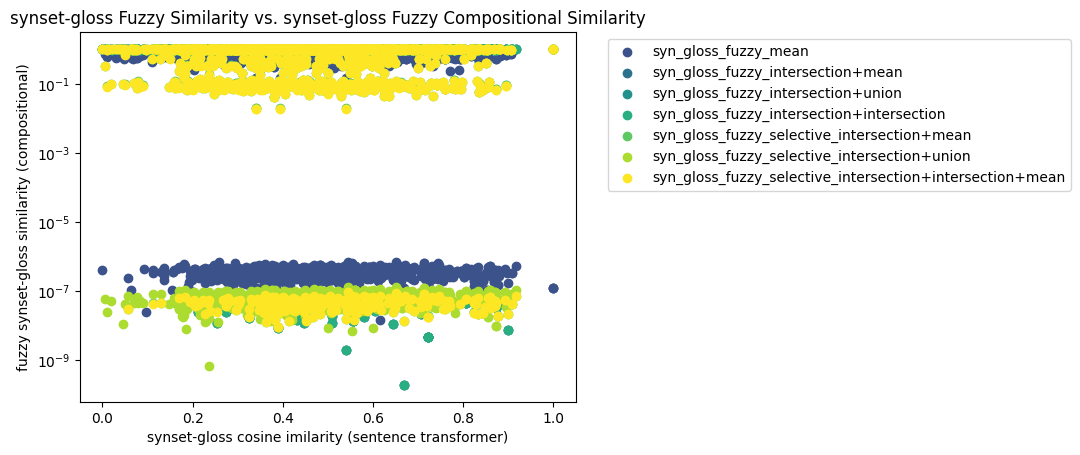

In [87]:
cmap = plt.get_cmap("viridis")
colors = cmap(np.linspace(0, 1, len(sim_eval_df.columns)))
for i, col in enumerate(sim_eval_df.columns):
  if col in ["syn_gloss_cos_sim", "is_related"]:
    continue
  plt.scatter(
      x=sim_eval_df["syn_gloss_cos_sim"],
      y=sim_eval_df[col],
      color=colors[i],
      label=col
  )

plt.xlabel("synset-gloss cosine imilarity (sentence transformer)")
plt.ylabel("fuzzy synset-gloss similarity (compositional)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale("log")
plt.title("synset-gloss Fuzzy Similarity vs. synset-gloss Fuzzy Compositional Similarity")
plt.show()

In [88]:
sim_eval_df.columns

Index(['syn_gloss_cos_sim', 'is_related', 'syn_gloss_fuzzy_mean',
       'syn_gloss_fuzzy_intersection+mean',
       'syn_gloss_fuzzy_intersection+union',
       'syn_gloss_fuzzy_intersection+intersection',
       'syn_gloss_fuzzy_selective_intersection+mean',
       'syn_gloss_fuzzy_selective_intersection+union',
       'syn_gloss_fuzzy_selective_intersection+intersection+mean'],
      dtype='object')

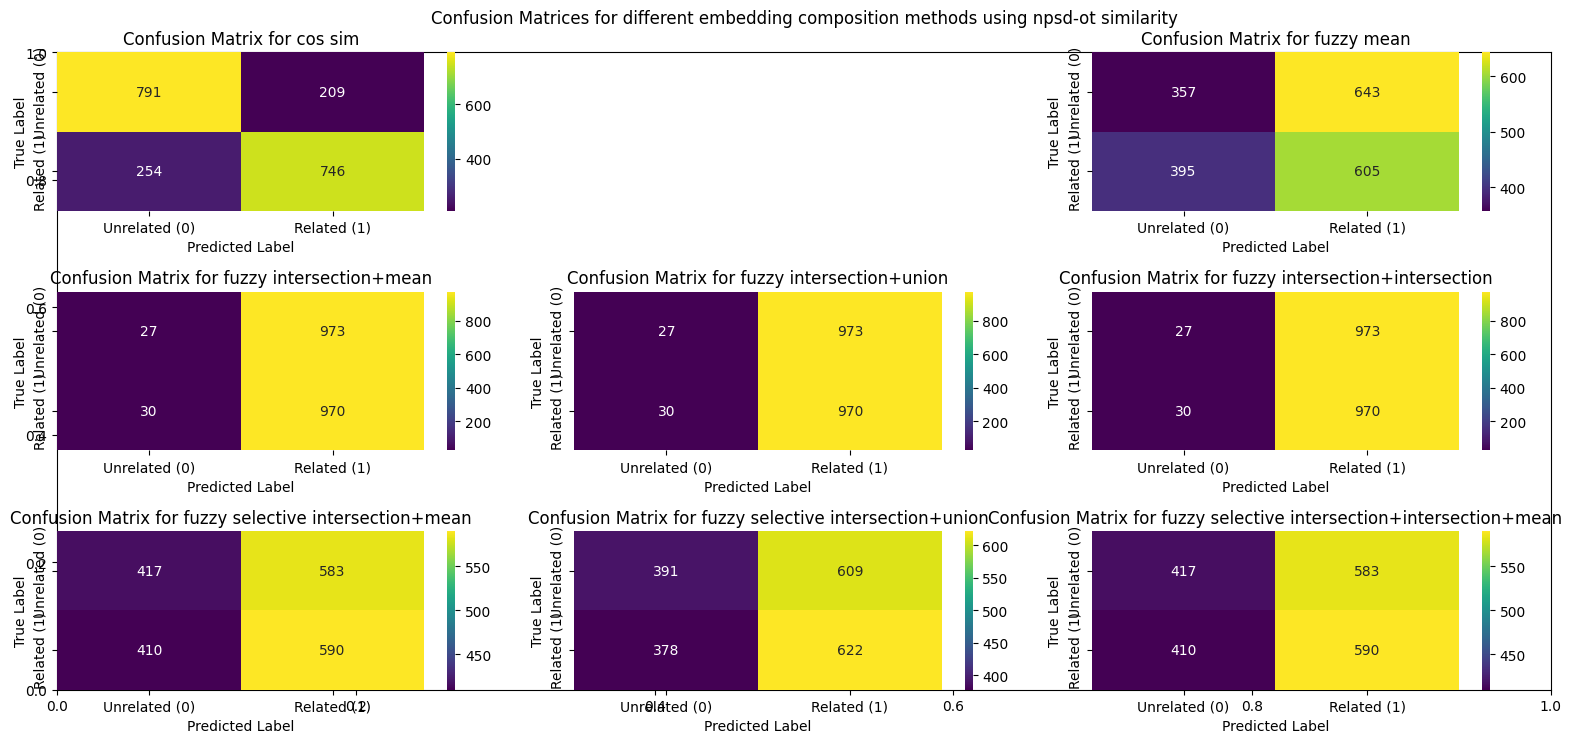

In [89]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(16, 8))

plt.title(f"Confusion Matrices for different embedding composition methods using {sim_metric} similarity\n")
for i, col in enumerate(sim_eval_df.columns):
    if col in ["is_related"]:
      continue

    # Calculate confusion matrix
    cm = confusion_matrix(
        sim_eval_df['is_related'],
         (sim_eval_df[col] >= sim_eval_df[col].mean()).astype(int)
    )

    # Plot confusion matrix
    plt.subplot(3, 3, i+1)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='viridis',
        xticklabels=['Unrelated (0)', 'Related (1)'],
        yticklabels=['Unrelated (0)', 'Related (1)']
    )
    plt.title(f'Confusion Matrix for {col.replace("syn_gloss_", "").replace("_", " ")}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# Stat analysis

## Correlation coefficients

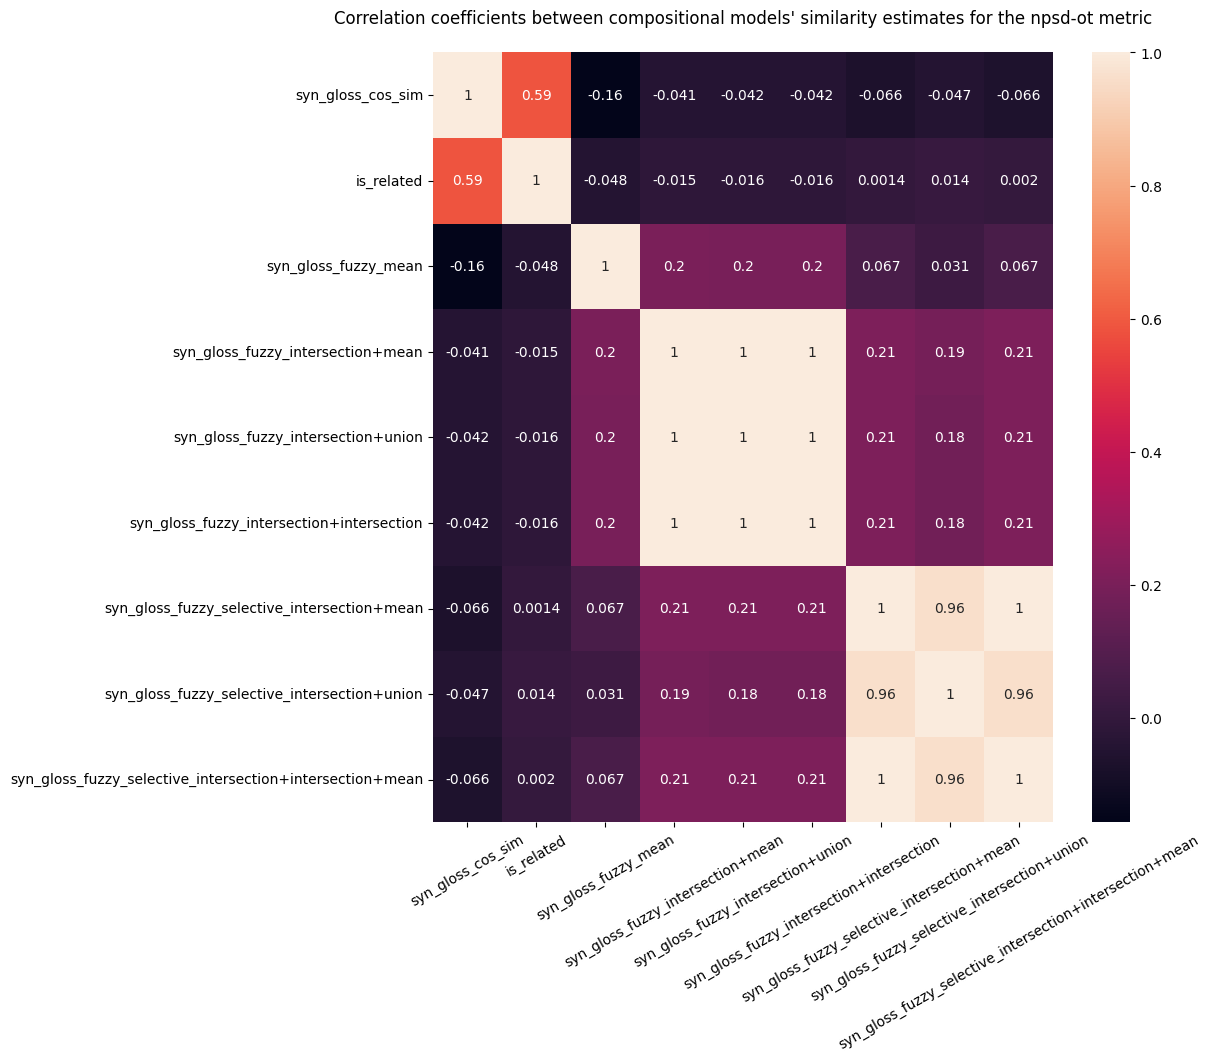

In [90]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(sim_eval_df.corr(), annot=True)
ax.tick_params(axis='x', labelrotation=30)
plt.title(f"Correlation coefficients between compositional models' similarity estimates for the {sim_metric} metric\n")
plt.show()

## Comparing composition strategies' differentiation capability between related and unrelated glosses

In [91]:
sep_eval_dict = {
    "mean_cos_similarity": [],
    "cos_separability": []
}
for s in strategies:
  sep_eval_dict[f"separability_{s}"] = []

In [92]:
for i in range(0, len(sim_eval_df), 2):
  # cosine similarity
  sep_eval_dict["mean_cos_similarity"].append(sim_eval_df.loc[i, "syn_gloss_cos_sim"]/2 + sim_eval_df.loc[i+1, "syn_gloss_cos_sim"]/2)
  sep_eval_dict["cos_separability"].append(sim_eval_df.loc[i, "syn_gloss_cos_sim"] - sim_eval_df.loc[i+1, "syn_gloss_cos_sim"])
  for s in strategies:
    strat = f"syn_{gloss_vect_fuzzy_cols[s]}"
    sep_eval_dict[f"separability_{s}"] = sim_eval_df.loc[i, strat] - sim_eval_df.loc[i+1, strat]

sep_eval_df = pd.DataFrame.from_dict(sep_eval_dict)

## Visuals

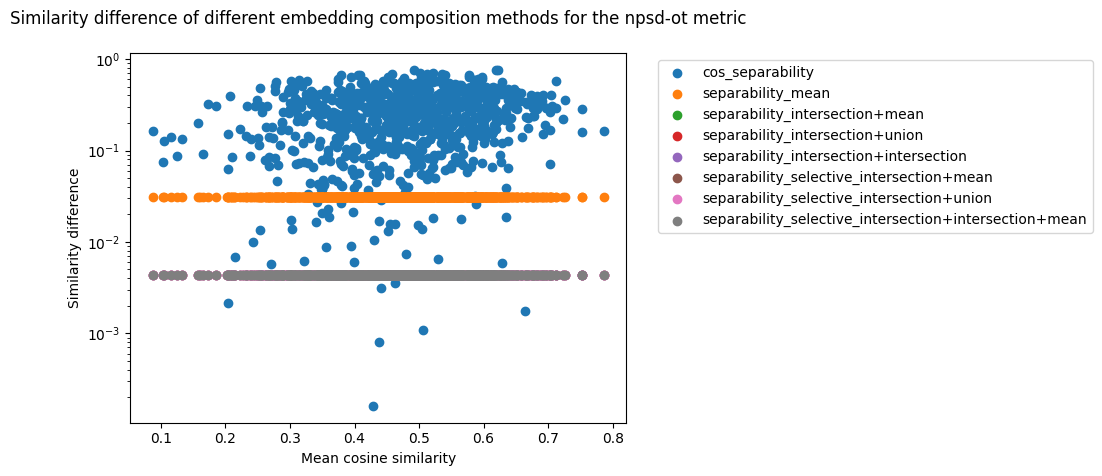

In [93]:
for c in sep_eval_df.columns:
  if c in ["mean_cos_similarity"]:
    continue
  plt.scatter(
      x=sep_eval_df["mean_cos_similarity"],
      y=sep_eval_df[c],
      label=c
  )
plt.xlabel("Mean cosine similarity")
plt.ylabel("Similarity difference")
# plt.xscale("log")
plt.yscale("log")
plt.legend(
    [c for c in sep_eval_df.columns if c not in ["mean_cos_similarity"]],
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.title(f"Similarity difference of different embedding composition methods for the {sim_metric} metric\n")
plt.show()

del sep_eval_df["mean_cos_similarity"]

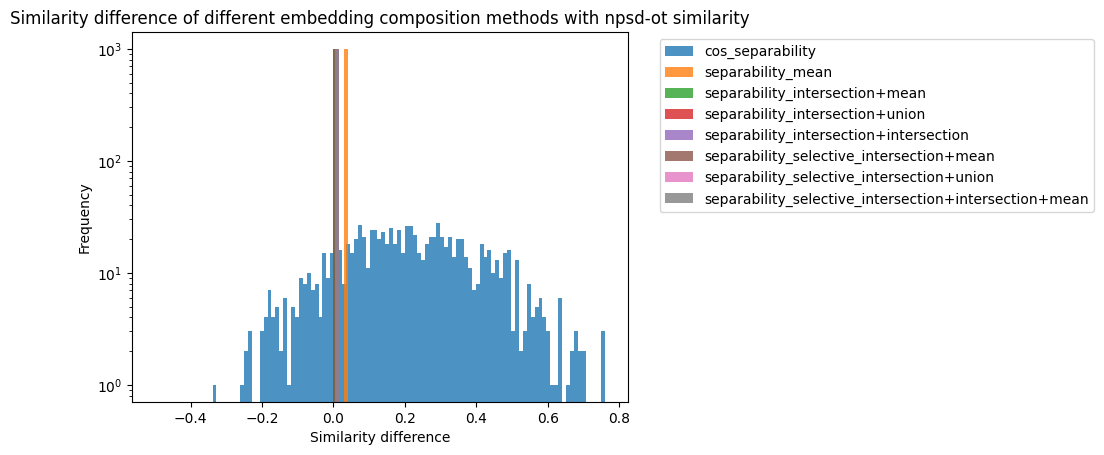

In [99]:
for col in sep_eval_df.columns:
  plt.hist(
      sep_eval_df[col],
      bins=100,
      alpha=0.8,
      # range=(-.01, .01)
  )

plt.xlabel("Similarity difference")
plt.ylabel("Frequency")
# plt.xscale("log")
plt.yscale("log")
plt.legend(
    sep_eval_df.columns,
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)
plt.title(f"Similarity difference of different embedding composition methods with {sim_metric} similarity")
plt.show()

## Significance tests for separability

In [95]:
print("p-value for separability of...")
for col in sep_eval_df.columns:
  # get probability mean(eval_df["separability_fuzzy"]) > 0
  p = stats.ttest_1samp(
      sep_eval_df[col],
      0,
      alternative="greater"
  ).pvalue
  print(f"\t{col} > 0:{'\t'*(10 - len(col)//7)}{p}")

p-value for separability of...
	cos_separability > 0:								4.953239437607243e-180
	separability_mean > 0:								0.0
	separability_intersection+mean > 0:						1.0
	separability_intersection+union > 0:						0.0
	separability_intersection+intersection > 0:					0.0
	separability_selective_intersection+mean > 0:					1.0
	separability_selective_intersection+union > 0:					0.0
	separability_selective_intersection+intersection+mean > 0:			0.0


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
